
# DA5401 A6 — Imputation via Regression for Missing Data

**Swara Patil - MM22B045** 

---

### Objective
We'll explore different strategies to handle **missing data** in the **UCI Credit Card Default dataset**:
1. Simple Imputation  
2. Linear Regression Imputation  
3. KNN (Non-linear) Regression Imputation  
4. Listwise Deletion  

Then, we'll evaluate how each method affects classification performance using **Logistic Regression**.

---


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


## 1️ Loading Dataset

In [60]:
DATA_PATH = 'UCI_Credit_Card.csv'

df = pd.read_csv(DATA_PATH)
print('\nData shape:', df.shape)
df.head(1)


Data shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1



### Data Cleaning
We'll remove the `ID` column (it's just an identifier and doesn't carry predictive information).


In [61]:
df = df.drop(columns=['ID'], errors='ignore')
print('Shape after dropping ID:', df.shape)

Shape after dropping ID: (30000, 24)


In [62]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


## 2️ Introducing Missing Values (MAR)
We’ll artificially introduce 7% missing values into:
- `AGE`
- `BILL_AMT1`
- `PAY_AMT1`

This simulates a real-world missing-at-random (MAR) situation.


In [54]:
rng = np.random.RandomState(42)
missing_frac = 0.07
cols_to_miss = ['AGE', 'BILL_AMT1', 'PAY_AMT1']

for c in cols_to_miss:
    mask = rng.rand(len(df)) < missing_frac
    df.loc[mask, c] = np.nan

df[cols_to_miss].isna().sum()

AGE          2105
BILL_AMT1    2095
PAY_AMT1     2092
dtype: int64

/home/swara/jupyter_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


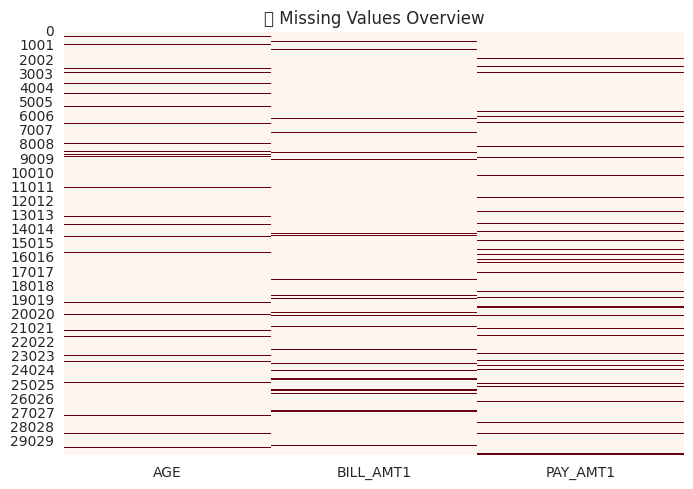

In [55]:
sns.heatmap(df[cols_to_miss].isna(), cbar=False, cmap='Reds')
plt.title("🔎 Missing Values Overview")
plt.show()


## 3️ Part A — Imputation Strategies
We'll create four versions of the dataset:

| Dataset | Strategy | Description |
|----------|-----------|-------------|
| **A** | Median Imputation | Simple baseline |
| **B** | Linear Regression | Predict missing using linear relations |
| **C** | KNN Regression | Capture non-linear patterns |
| **D** | Listwise Deletion | Remove all missing rows |

Let's start with **Dataset A**.


### Dataset A — Simple Imputation

In [34]:
A = df.copy()
median_imputer = SimpleImputer(strategy='median')
num_cols = A.select_dtypes(include=[np.number]).columns
A[num_cols] = median_imputer.fit_transform(A[num_cols])
print("Remaining NaNs in A:", A.isna().sum().sum())

Remaining NaNs in A: 0


### Why Median is Often Preferred Over Mean for Imputation

The median is often preferred over the mean when filling missing values because it is **less affected by outliers**. Extreme values can skew the mean, making it less representative of the typical data point, while the median gives a value that better reflects the center of the data. 

## For Datasets B and C,

The assignment requires us to apply regression imputation to **only one column**. In our case, we use regression models to predict **AGE**, while the other columns with missing values (**BILL_AMT1** and **PAY_AMT1**) are filled using their **median values**.  

For Datasets B and C, we use **median imputation for the other two columns** rather than the original fully filled values. This keeps the comparison **fair**, because if we used the original filled values, imputation in B and C would only affect one column, whereas in Dataset A, imputation is applied to all three columns. Using the median for the remaining columns ensures consistency in how missing values are handled across all datasets.


### Dataset B — Linear Regression Imputation (on `AGE`)

In [35]:
B = df.copy()
target = 'AGE'
reg_cols = [c for c in B.select_dtypes(include=[np.number]).columns if c != target and c != 'default.payment.next.month']

# fill other cols with median
for c in ['BILL_AMT1', 'PAY_AMT1']:
    if c in B.columns:
        B[c] = B[c].fillna(B[c].median())

# linear regression
train_mask = B[target].notna()
X_train = B.loc[train_mask, reg_cols]
y_train = B.loc[train_mask, target]

X_train = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_train),
                       columns=reg_cols, index=X_train.index)

lr = LinearRegression()
lr.fit(X_train, y_train)

missing_mask = B[target].isna()
X_missing = B.loc[missing_mask, reg_cols]
X_missing = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_missing),
                         columns=reg_cols, index=X_missing.index)

B.loc[missing_mask, target] = lr.predict(X_missing)

print("Remaining NaNs in B:", B.isna().sum().sum())


Remaining NaNs in B: 0


### Underlying Assumption of Regression Imputation

Regression imputation assumes that the missing values in a column are **Missing At Random (MAR)**. This means that the likelihood of a value being missing depends only on the **other observed features**, and not on the missing values themselves. Means, we assume that the missing entries can be reasonably predicted using the relationships with other columns in the dataset. This allows a regression model to estimate the missing values based on patterns present in the available data, making the imputed values consistent with the overall dataset.


### Dataset C — Non-linear Regression Imputation (KNN)

In [36]:
C = df.copy()
target = 'AGE'
reg_cols = [c for c in C.select_dtypes(include=[np.number]).columns if c not in [target, 'default.payment.next.month']]

# Fill other col using median
for c in ['BILL_AMT1', 'PAY_AMT1']:
    if c in C.columns:
        C[c] = C[c].fillna(C[c].median())

# KNN regressor
train_mask = C[target].notna()
X_train = C.loc[train_mask, reg_cols]
y_train = C.loc[train_mask, target]

X_train = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_train),
                       columns=reg_cols, index=X_train.index)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

missing_mask = C[target].isna()
if missing_mask.any():
    X_missing = C.loc[missing_mask, reg_cols]
    X_missing = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_missing),
                             columns=reg_cols, index=X_missing.index)
    C.loc[missing_mask, target] = knn.predict(X_missing)

print("Remaining NaNs in C:", C.isna().sum().sum())


Remaining NaNs in C: 0


### Dataset D — Listwise Deletion

In [37]:
D = df.dropna().copy()
print("Original shape:", df.shape, "| After listwise deletion:", D.shape)

Original shape: (30000, 24) | After listwise deletion: (24147, 24)



## 4️ Part B — Model Training & Evaluation
We’ll train a **Logistic Regression** classifier on each dataset (A, B, C, D).  
We'll compare **Accuracy**, **Precision**, **Recall**, and **F1-score**.


In [38]:
def train_and_evaluate(df, name):
    target_col = 'default.payment.next.month'
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'Dataset': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    return metrics

results = []
for name, data in zip(['A_Median', 'B_Linear', 'C_KNN', 'D_Listwise'], [A,B,C,D]):
    metrics = train_and_evaluate(data, name)
    print(metrics)
    results.append(metrics)
   
results_df = pd.DataFrame(results)
results_df

{'Dataset': 'A_Median', 'Accuracy': 0.8094666666666667, 'Precision': 0.7053571428571429, 'Recall': 0.23809523809523808, 'F1': 0.35601622352410994}
{'Dataset': 'B_Linear', 'Accuracy': 0.8094666666666667, 'Precision': 0.7039007092198581, 'Recall': 0.23930078360458107, 'F1': 0.3571749887539361}
{'Dataset': 'C_KNN', 'Accuracy': 0.8097333333333333, 'Precision': 0.7064056939501779, 'Recall': 0.23930078360458107, 'F1': 0.3574966231427285}
{'Dataset': 'D_Listwise', 'Accuracy': 0.8071890011595163, 'Precision': 0.7089552238805971, 'Recall': 0.21396396396396397, 'F1': 0.328719723183391}


,Dataset,Accuracy,Precision,Recall,F1
0,A_Median,0.809467,0.705357,0.238095,0.356016
1,B_Linear,0.809467,0.703901,0.239301,0.357175
2,C_KNN,0.809733,0.706406,0.239301,0.357497
3,D_Listwise,0.807189,0.708955,0.213964,0.328720


## 5️ Part C — Comparative Analysis

### Why Take Difference from Minimum?

When comparing performance metrics (Accuracy, Precision, Recall, F1) across multiple strategies, the absolute values are very close. So, a normal bar plot does **not visually highlight the small differences**.  

To make the differences clearer, we compute the **difference from the minimum value** for each metric:


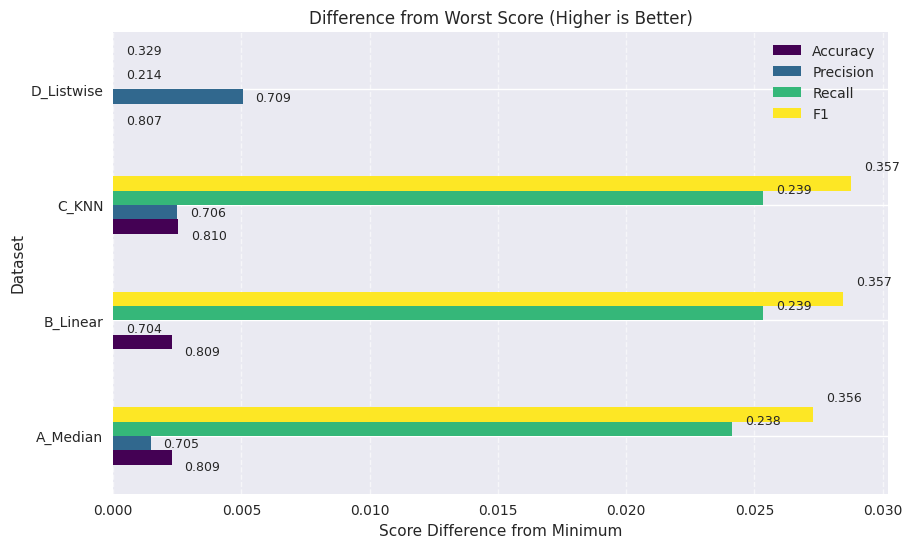

In [49]:
delta_df = results_df - results_df.min()

ax = delta_df.plot(kind='barh', figsize=(10,6), colormap='viridis')
plt.title("Difference from Worst Score (Higher is Better)")
plt.xlabel("Score Difference from Minimum")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

for i, row in enumerate(delta_df.values):
    for j, val in enumerate(row):
        ax.text(val + 0.0005, i + j*0.2 - 0.3, f"{results_df.values[i,j]:.3f}", fontsize=9)

plt.show()

### Discussion

Looking at the results, all four models perform quite closely in terms of accuracy, around 80%.  
But when we focus on the F1-score and recall — which reflect how well the model identifies default cases — some key differences appear.

- **Dataset A (Median Imputation)** works as a solid baseline. Even though it’s a simple approach, using the median gives fairly balanced results because it isn’t affected by extreme values or outliers.  
- **Dataset B (Linear Regression Imputation)** performs slightly better than the median approach. This makes sense — the regression model uses relationships among the features to estimate the missing `AGE` values, instead of just replacing them with a single statistic.  
- **Dataset C (KNN Imputation)** gives the highest F1-score, though only by a small margin. This suggests that the relationship between `AGE` and other variables might not be purely linear — KNN can capture subtle, non-linear trends that the linear model misses.  
- **Dataset D (Listwise Deletion)** performs the weakest, especially in recall. By removing all rows with missing data, we lose valuable information and end up training on a smaller, less representative dataset.

Overall, regression-based imputations (both linear and KNN) give slightly better performance because they use more information from the data to make informed guesses.  
The difference may look small in numbers, but it’s conceptually important — it shows how learning the structure of the data, rather than just filling gaps blindly, can improve model reliability.

**In summary:**  
If time and resources allow, regression-based imputation — especially non-linear methods like KNN — should be preferred.  
Median imputation remains a quick and robust choice for large datasets or early-stage experiments.  
Listwise deletion, however, should generally be avoided since it reduces data and weakens model generalization.
